# Calibration Tutorial - Fork Peck, MT - Unirrigated Flux Plot

## Step 4: Running the Calibrated Model

Now we see if we were able to improve the model's performance through calibration.

In [1]:
import os
import sys
import json
import toml
import time
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../../..')
sys.path.append(root)

from swim.config import ProjectConfig
from swim.sampleplots import SamplePlots
from model.etd import obs_field_cycle

from viz.param_evolution import plot_parameter_histograms
from viz.swim_timeseries import plot_swim_timeseries

In [2]:
project_ws = os.path.join(root, 'tutorials', '2_Fort_Peck')
data = os.path.join(project_ws, 'data')
pst = os.path.join(project_ws, 'pest')

Before we run the calibrated parameters in 'forecast' mode, let's see how they've changed from our initial conditions. A nice way to see the evolution of the parameters is to plot their hisograms from optimization step to optimization step:

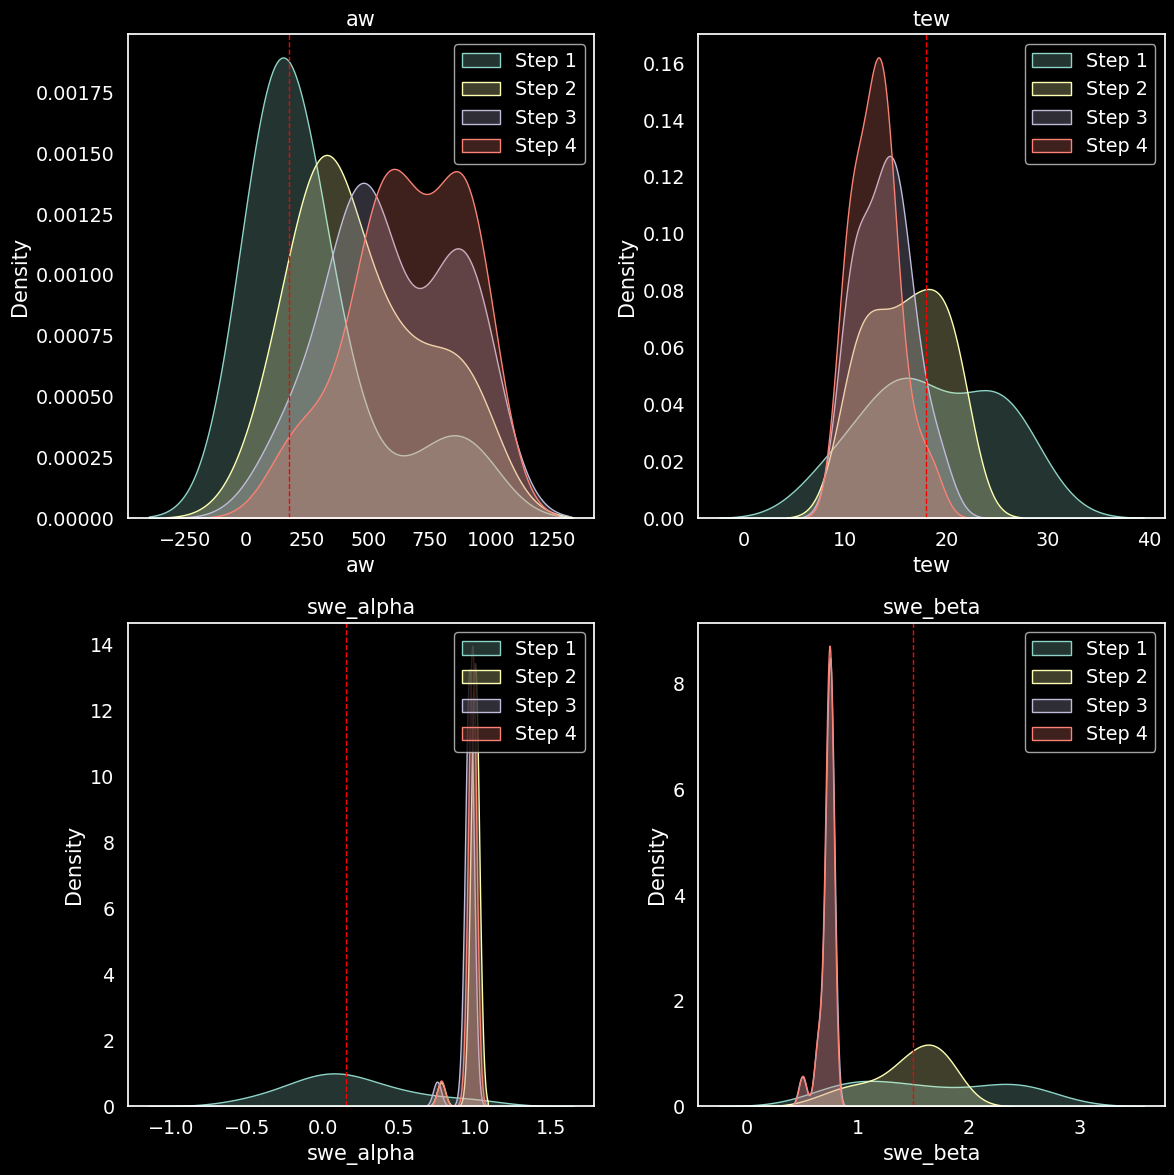

In [3]:
inital_params = os.path.join(project_ws, 'params.csv')
steps = [os.path.join(pst, f'2_Fort_Peck.{i}.par.csv') for i in range(4)]
fig_dir = os.path.join(project_ws, 'figures', 'parameter_hist')

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir, exist_ok=True)

# change to fig_out_dir=fig_dir to write the .png files to the 'figures' directory
plot_parameter_histograms(inital_params, steps, fig_out_dir=None)

Just as before, we'll define a model run script and validate with the flux data. To do so, we must modify the config file again, and turn off `calibration` mode and turn on `forecast` mode:

- Turn the calibration off by setting `calibrate_flag = 0`. You can leave the paths in the calibration section.
- Turn the forecast mode on by setting `forecast_flag = 1`.
- Set the `forecast_parameters = '{project_root}/pest/2_Fort_Peck.3.par.csv'`; this is where the final parameter proposal set is stored.
  

In [15]:
def run_fields(ini_path, project_ws, selected_feature, output_csv, forecast=False):
    start_time = time.time()

    config = ProjectConfig()
    config.read_config(ini_path, project_ws, forecast=forecast)

    fields = SamplePlots()
    fields.initialize_plot_data(config)
    fields.output = obs_field_cycle.field_day_loop(config, fields, debug_flag=True)

    end_time = time.time()
    print('\nExecution time: {:.2f} seconds\n'.format(end_time - start_time))

    out_df = fields.output[selected_feature].copy()

    in_df = fields.input_to_dataframe(selected_feature)

    df = pd.concat([out_df, in_df], axis=1, ignore_index=False)
    df.to_csv(output_csv)

In [16]:
project_ws = os.path.join(root, 'tutorials', '2_Fort_Peck')

data = os.path.join(project_ws, 'data')

config_file = os.path.join(project_ws, 'config.toml')
prepped_input = os.path.join(data, 'prepped_input.json')

selected_feature = 'US-FPe'
out_csv = os.path.join(project_ws, 'step_4_calibrated_model', f'combined_output_{selected_feature}.csv')

run_fields(config_file, project_ws, selected_feature=selected_feature, output_csv=out_csv, forecast=True)



Config: /home/dgketchum/PycharmProjects/swim-rs/tutorials/2_Fort_Peck/config.toml
CALIBRATION OFF
FORECAST ON
aw: ['666.39']
ndvi_alpha: ['0.18']
swe_beta: ['0.72']
rew: ['2.50']
swe_alpha: ['0.97']
tew: ['12.98']
mad: ['0.51']
ndvi_beta: ['1.26']

Execution time: 11.57 seconds



total irrigation: 0.0
total et: 307.7
total precip: 312.0


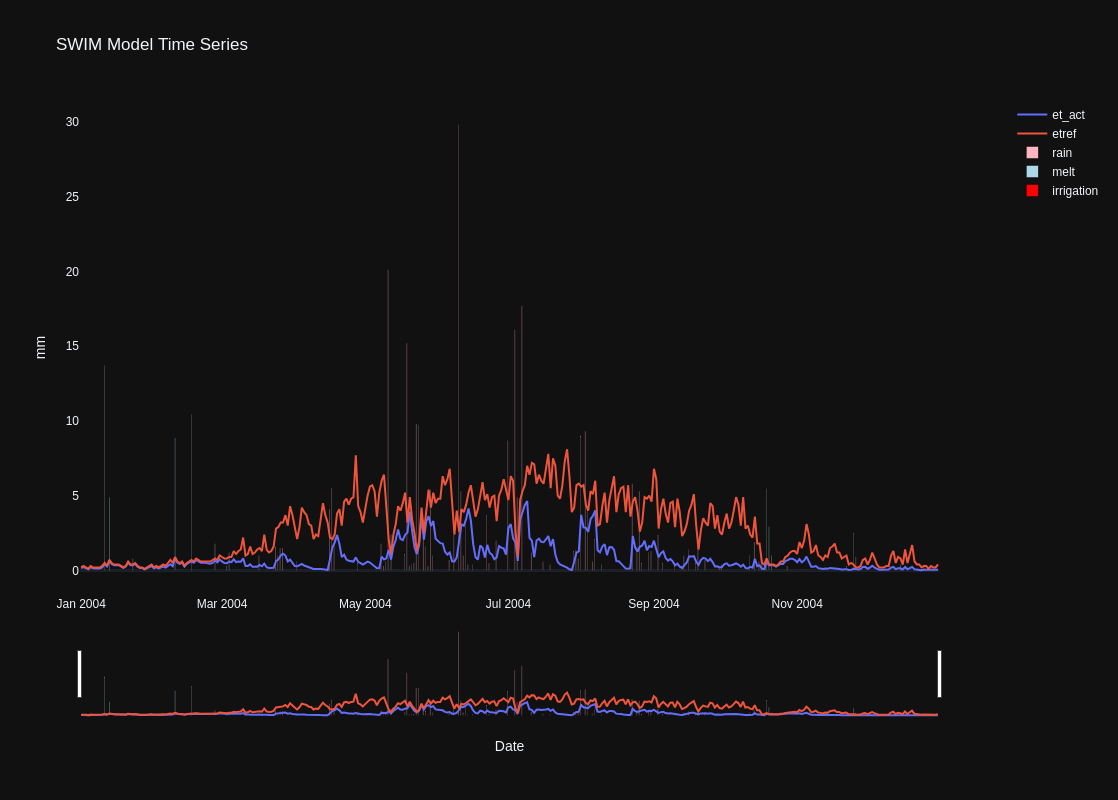

In [19]:
df = pd.read_csv(out_csv, index_col=0, parse_dates=True)

ydf = df.loc['2004-01-01': '2004-12-31']
print(f'total irrigation: {ydf.irrigation.sum():.1f}')
print(f'total et: {ydf.et_act.sum():.1f}')
print(f'total precip: {ydf.ppt.sum():.1f}')
plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], start='2004-01-01', end='2004-12-31', png_file='et.png')

<img src='et.png'> 

In [18]:
def compare_etf_estimates(combined_output_path, flux_data_path):
    flux_data = pd.read_csv(flux_data_path)
    flux_data = flux_data.set_index(pd.to_datetime(flux_data['date']))['EToF']

    combined_output = pd.read_csv(combined_output_path, index_col=0)
    combined_output.index = pd.to_datetime(combined_output.index)

    df = pd.DataFrame({'kc_act': combined_output['kc_act'],
                       'etf_inv_irr': combined_output['etf_inv_irr'],
                       'etf_inv_irr_ct': combined_output['etf_inv_irr_ct'],
                       'EToF': flux_data})

    # filter for days that have a SSEBop ETf retrieval and a flux observation
    df = df.dropna()
    df = df.loc[df['etf_inv_irr_ct'] == 1]

    # Calculate RMSE and R-squared
    rmse_kc_act = np.sqrt(mean_squared_error(df['EToF'], df['kc_act']))
    r2_kc_act = r2_score(df['EToF'], df['kc_act'])

    rmse_ssebop = np.sqrt(mean_squared_error(df['EToF'], df['etf_inv_irr']))
    r2_ssebop = r2_score(df['EToF'], df['etf_inv_irr'])

    print(f"SWIM Kc_act vs. Flux EToF: RMSE = {rmse_kc_act:.2f}, R-squared = {r2_kc_act:.2f}")
    print(f"SSEBop ETf vs. Flux EToF: RMSE = {rmse_ssebop:.2f}, R-squared = {r2_ssebop:.2f}")
    
flux_data = os.path.join(data, 'US-FPe_daily_data.csv')
compare_etf_estimates(out_csv, flux_data)

SWIM Kc_act vs. Flux EToF: RMSE = 0.16, R-squared = 0.36
SSEBop ETf vs. Flux EToF: RMSE = 0.25, R-squared = -0.48


Wow! We knocked off a huge fraction of the error (>40%) from our initial model, and now have a daily water balance with an ET component that is substantially more accurate than using remote sensing alone!

This result suggests the promise of this approach. It's hard to set up, but can really improve daily estimates.

**The key insight is that we can mine the deep remote sensing-based ET record, but rather than driving the model with remote sensing ET directly, we drive the calibration with it. The fact the model has access to daily meteorological data and the flexibility to tune it's own parameters appears to give it a more grounded perspective on daily fluxes, and thus better estimates of ET generally.**